**STEP 1** LOAD_DATA, HIGH_PASS_FILTER, FOUIREROVA TRANSFORMACE, FIND_PEAKS, BASELINE_WANDER

In [3]:
import wfdb
from wfdb import processing
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import os 
import pandas as pd

import numpy as np
import wfdb

def center_ecg_signal(ecg_signal):
    """Zarovná EKG signál k ose X odečtením střední hodnoty"""
    return ecg_signal - np.mean(ecg_signal)

def load_data(path):
    """Načte soubor databáze a vrátí vzorky signálu EKG a seznam polí"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:, 0].flatten()
        
        # Zarovnání signálu na osu X
        ecg = center_ecg_signal(ecg)

        # Poté aplikujeme filtr
        ecg = high_pass_filter(ecg, fields["fs"])
        
        return ecg, fields
    
    except Exception as e:
        print(f"Chyba při načítání dat: {e}")
        return None, None

def compute_bpm(r_peaks, samp_rate, window_size=15):
    """
    Spočítá BPM (tepovou frekvenci) v daných časových oknech.
    - r_peaks: seznam indexů R-vrcholů
    - samp_rate: vzorkovací frekvence
    - window_size: délka okna v sekundách (defaultně 15s)
    """
    signal_duration = r_peaks[-1] / samp_rate  # Celková délka signálu v sekundách
    num_windows = int(signal_duration // window_size)  # Počet oken

    bpm_values = []
    for i in range(num_windows):
        start_time = i * window_size
        end_time = (i + 1) * window_size

        # Počet R-vrcholů v okně
        peak_count = sum((start_time * samp_rate <= p < end_time * samp_rate) for p in r_peaks)
        
        # Převod na BPM
        bpm = peak_count * (60 / window_size)
        bpm_values.append(bpm)

    return bpm_values

def estimate_threshold(signal, perc=95):
    return np.percentile(signal, perc)

def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Odebere baseline wander pro lepší manipulaci s daty pomocí Fourierovy transformace
    k nalezení nízkofrekvenčních komponent a jejich odstranění."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1 / sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline

def find_Rpeaks(signal):
    """Najde R píky v EKG signálu s dynamicky se měnící velikostí okna.
    Vrátí seznam píků a odpovídajících časů."""
    threshold = estimate_threshold(signal)
    peaks = []
    is_peak = False
    current_peak_value = -np.inf
    current_peak_index = 0

    for i, value in enumerate(signal):
        if value > threshold:
            if not is_peak or value > current_peak_value:
                current_peak_value = value
                current_peak_index = i
            is_peak = True
        else:
            if is_peak:
                peaks.append(current_peak_index)
                is_peak = False
    return np.array(peaks)

def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    """Počítá počet R píků každých 15 sekund"""
    signal_duration = len(signal) / samp_rate
    window_duration = 10.0
    window_count = int(signal_duration / window_duration)

    r_peak_counts = [0] * window_count

    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1

    return r_peak_counts

def plot_bpm_over_time(bpm_values, driver, window_duration=10.0):
    """Graf BPM"""
    time_axis = [i * window_duration / 60.0 for i in range(len(bpm_values))]
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, bpm_values, linestyle='-', color='b')
    plt.title('BPM v čase ' + driver)
    plt.xlabel('Minut')
    plt.ylabel('BPM')
    plt.grid(True)
    plt.show()

**STEP 2** VIZUALIZACE SIGNÁLU ECG

Obsah složky data\100002: ['100002_ACC.dat', '100002_ACC.hea', '100002_ANN.csv', '100002_ECG.dat', '100002_ECG.hea']
Vzorkovací frekvence: 1000 Hz
Velikost signálu: 86762000 vzorků
[      0    1791    2363 ... 5997188 5998704 5999431]
Průměrné BPM: 106.80701754385964


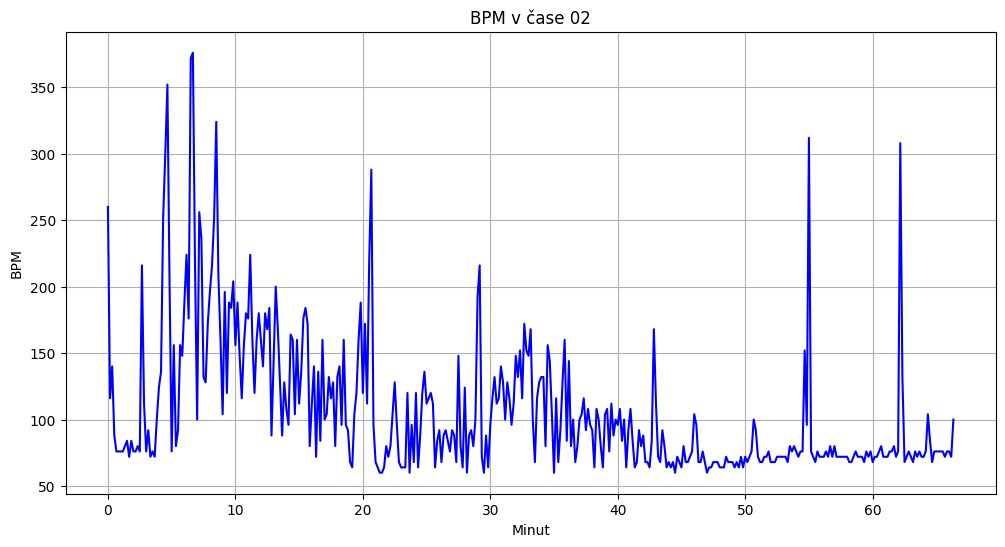

In [20]:
import os
import numpy as np
import wfdb

database_folder = "data"
record_name = "100002"  # 103001
database = os.path.join(database_folder, record_name)

files = os.listdir(database)
print(f"Obsah složky {database}: {files}")

ecg_base_name = None
for file in files:
    if file.endswith("_ECG.dat"):
        ecg_base_name = file[:-4]
        break

if ecg_base_name is None:
    raise FileNotFoundError(f"V {database} chybí správný .hea soubor pro EKG!")

record_path = os.path.join(database, ecg_base_name)

# Načtení dat WFDB
record = wfdb.rdrecord(record_path)
fs = record.fs  # Vzorkovací frekvence
ecg_data = record.p_signal[:, 0]  # Pouze první kanál

print(f"Vzorkovací frekvence: {fs} Hz")
print(f"Velikost signálu: {len(ecg_data)} vzorků")

# Načítání po menších částech, pokud je signál příliš velký
if len(ecg_data) > 6000000:
    ecg_data = ecg_data[:6000000]  # Použij jen první milion vzorků

# Odstranění baseline wander
cutoff_frequency = 0.5
ecg_edit_fft = remove_baseline_wander_fft(ecg_data, fs, cutoff_frequency=cutoff_frequency)
Rpeaks = find_Rpeaks(ecg_edit_fft)
print(Rpeaks)
# Výpočet BPM v časových oknech
r_peak_counts = [count * 4 for count in count_rpeaks_in_windows(ecg_edit_fft, Rpeaks, fs)]

# Po detekci R-píků
bpm_values = compute_bpm(Rpeaks, fs, window_size=15)
# Vypočítání průměrného BPM signálu
average_bpm = np.mean(bpm_values)
print(f"Průměrné BPM: {average_bpm}")
# Vykreslení BPM v čase
plot_bpm_over_time(bpm_values, record_name[-2:])


In [4]:
def evaluate_detection(true_peaks, detected_peaks, correct_threshold=0.0001):
    correct = 0
    total = len(true_peaks)
    for true_peak in true_peaks:
        detected = False
        for detected_peak in detected_peaks:
            delta = (true_peak+1) / (detected_peak+1)
            deltap = np.abs(1-delta)
            if deltap < correct_threshold:
                detected = True
                break

        if detected:
            correct += 1

    return correct, total - correct, total, len(detected_peaks)

def test_file(file_path, sampfrom=0, nsamp=100000, correct_threshold=0.0001):
    signal, _ = wfdb.rdsamp(file_path, channels=None, sampfrom=sampfrom, sampto=sampfrom+nsamp)
    true_peaks = wfdb.rdann(file_path, extension="atr", sampfrom=sampfrom, sampto=sampfrom+nsamp).sample
    signal = signal[:, 0]
    detected_peaks = find_Rpeaks(signal)
    return evaluate_detection(true_peaks, detected_peaks, correct_threshold)

**STEP 3** SPUŠTĚNÍ ALGORITMU NAD TEST DATY

In [9]:
import os
import pandas as pd

success_count = 0
total_count = 0

data = []

for file in os.listdir("testdata/"):
    if file[-3:] != "dat":
        continue
    
    file = file[:-4]
    correct, wrong, total, peaks = test_file("testdata/" + file)
    success_count += correct
    total_count += total

    success_rate = correct / total * 100

    data.append([file, correct, wrong, total, success_rate])

df = pd.DataFrame(data, columns=["File", "Správně", "Špatně", "Total", "Úspěšnost (%)"])
total_success_rate = success_count / total_count * 100

print("Výsledky nad test daty:")
print(df)
print(f"Úspěšnost: {total_success_rate:.2f}%")

Výsledky nad test daty:
     File  Správně  Špatně  Total  Úspěšnost (%)
0   16265     1141     176   1317      86.636295
1   16272      797     200    997      79.939819
2   16273     1006     237   1243      80.933226
3   16420      905     249   1154      78.422877
4   16483      930     241   1171      79.419300
5   16539     1028      67   1095      93.881279
6   16773      822     569   1391      59.094177
7   16786      754     210    964      78.215768
8   16795      756     303   1059      71.388102
9   17052      859     259   1118      76.833631
10  17453      930     104   1034      89.941973
11  18177     1214     279   1493      81.312793
12  18184      918     283   1201      76.436303
13  19088      977     404   1381      70.745836
14  19090     1034     114   1148      90.069686
15  19093      771     190    961      80.228928
16  19140      995     268   1263      78.780681
17  19830     1263     161   1424      88.693820
Úspěšnost: 79.85%


**STEP 4** IDENTIFIKACE ANOMÁLIÍ

In [29]:
import pandas as pd

annotations = pd.read_csv('data/100001/100001_ANN.csv', header=None)

# Filtrování segmentů, které nejsou kódem 1 (normální události)
anomalous_segments = annotations[annotations[2] != 1]

# Počet anomálií
num_anomalies = len(anomalous_segments)
print(f"Počet anomálií: {num_anomalies}")


Počet anomálií: 1147


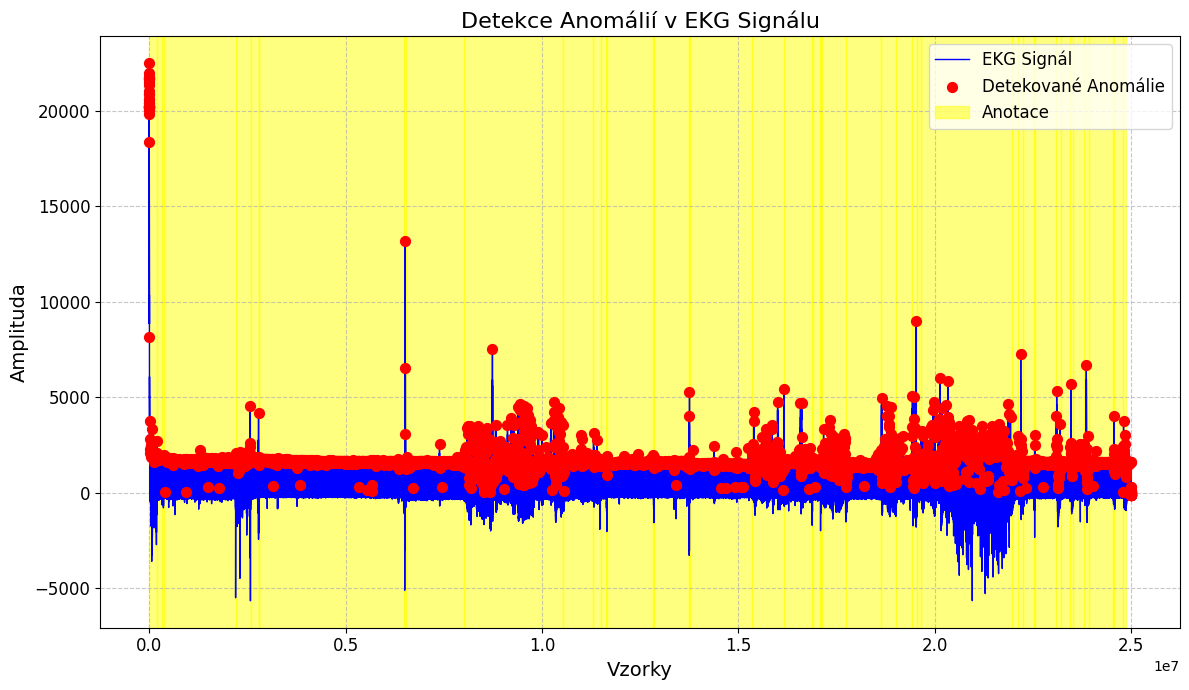

Počet anomálií (dle anotací): 1147
Počet detekovaných anomálií: 3718
Počet shodných anotací: 47
Úspěšnost detekce: 100.00%


In [1]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

# Funkce pro detekci anomálií pomocí Fourierovy transformace
def detect_anomalies_fft(signal, threshold_freq=1000.0):
    fft_signal = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_signal)
    mean_freq = np.mean(fft_magnitude)
    
    anomalies = np.where(fft_magnitude > threshold_freq * mean_freq)[0]
    return anomalies

# Funkce pro detekci anomálií pomocí klouzavého průměru a standardní odchylky
def detect_anomalies_rolling(signal, window_size=100, threshold_time=15.5):
    # Opravený výpočet s ohledem na velikost signálu
    rolling_mean = np.convolve(signal, np.ones(window_size) / window_size, mode='same')  # Změněno na 'same'
    rolling_std = np.sqrt(np.convolve((signal - rolling_mean) ** 2, np.ones(window_size) / window_size, mode='same'))  # Změněno na 'same'
    
    anomalies = np.where(np.abs(signal - rolling_mean) > threshold_time * rolling_std)[0]
    return anomalies

# Funkce pro detekci anomálií pomocí interkvartilního rozsahu (IQR)
def detect_anomalies_iqr(signal, threshold=150.5):
    Q1 = np.percentile(signal, 25)
    Q3 = np.percentile(signal, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    anomalies = np.where((signal < lower_bound) | (signal > upper_bound))[0]
    
    return anomalies

# Funkce pro detekci anomálií pomocí detekce vrcholů (peaks)
def detect_anomalies_peaks(signal, height=15.5, distance=800):
    peaks, _ = find_peaks(signal, height=height, distance=distance)
    return peaks

# Funkce pro filtrování signálu pomocí nízkofrekvenčního filtru
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(signal, cutoff, fs):
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, signal)

# Funkce pro zpracování signálu a porovnání s anotacemi
def process_signal(record_path, ann_path, sampling_rate=1000, duration=25000, threshold_freq=1000.0, threshold_time=15.5, height=15.5):
    try:
        record = wfdb.rdrecord(record_path)
        signal_length = len(record.p_signal)
        max_samples = min(sampling_rate * duration, signal_length)
        signal = record.p_signal[:max_samples, 0]

        # Použití Fourierovy transformace k detekci anomálií
        anomalies_fft = detect_anomalies_fft(signal, threshold_freq)

        # Použití klouzavého průměru a odchylky k detekci anomálií
        anomalies_rolling = detect_anomalies_rolling(signal, window_size=1000, threshold_time=threshold_time)

        # Použití IQR pro detekci anomálií
        anomalies_iqr = detect_anomalies_iqr(signal, threshold=150.5)

        # Použití detekce vrcholů k detekci anomálií
        anomalies_peaks = detect_anomalies_peaks(signal, height=height, distance=5000)

        # Kombinování všech detekovaných anomálií
        anomalies_combined = np.unique(np.concatenate([anomalies_fft, anomalies_rolling, anomalies_iqr, anomalies_peaks]))

        annotations = pd.read_csv(ann_path, header=None)
        annotation_start = annotations.iloc[:, 0].values
        annotation_end = annotations.iloc[:, 1].values

        valid_annotations = (annotation_start < max_samples) & (annotation_end < max_samples)
        annotation_start = annotation_start[valid_annotations]
        annotation_end = annotation_end[valid_annotations]

        matching_annotations = sum(1 for start, end in zip(annotation_start, annotation_end) if any(start <= anomaly < end for anomaly in anomalies_combined))
        total_annotations = len(annotation_start)

        num_anomalies = len(anomalies_combined)
        success_rate = matching_annotations / total_annotations if total_annotations > 0 else 0

        # Vylepšená vizualizace
        plt.figure(figsize=(12, 7))
        plt.plot(signal, label='EKG Signál', color='blue', linewidth=1)
        plt.scatter(anomalies_combined, signal[anomalies_combined], color='red', label='Detekované Anomálie', zorder=5, s=50)

        for start, end in zip(annotation_start, annotation_end):
            plt.axvspan(start, end, color='yellow', alpha=0.5, label='Anotace' if start == annotation_start[0] else "")

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Vzorky', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, loc='upper right')
        plt.tight_layout()
        plt.show()

        return num_anomalies, matching_annotations, success_rate

    except Exception as e:
        print(f"Chyba při zpracování {record_path}: {e}")
        return 0, 0, 0

record_path = 'data/100001/100001_ECG'  # Cesta k souboru EKG signálu
ann_path = 'data/100001/100001_ANN.csv'  # Cesta k souboru anotací

num_anomalies, num_matching, success_rate = process_signal(record_path, ann_path)

annotations = pd.read_csv(ann_path, header=None)
anomalous_segments = annotations[annotations[2] != 1]
success_percentage = success_rate * 100
num_anomaliesann = len(anomalous_segments)
print(f"Počet anomálií (dle anotací): {num_anomaliesann}")
print(f"Počet detekovaných anomálií: {num_anomalies}")
print(f"Počet shodných anotací: {num_matching}")
print(f"Úspěšnost detekce: {success_percentage:.2f}%")

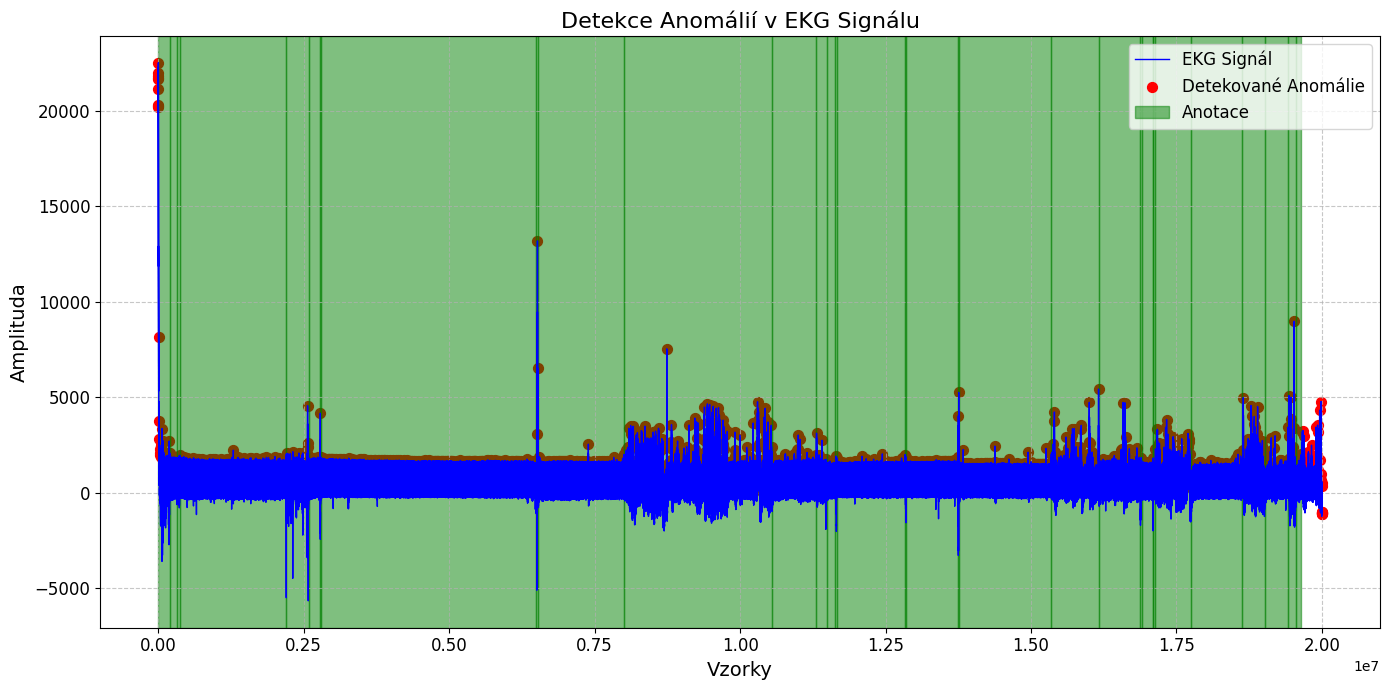

Počet anomálií (dle anotací): 1147
Počet detekovaných anomálií: 2957
Počet shodných anotací: 32
Úspěšnost detekce: 100.00%


In [90]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

# Funkce pro detekci anomálií pomocí Fourierovy transformace
def detect_anomalies_fft(signal, threshold_freq=1000.0):
    fft_signal = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_signal)
    mean_freq = np.mean(fft_magnitude)
    
    anomalies = np.where(fft_magnitude > threshold_freq * mean_freq)[0]
    return anomalies

# Funkce pro detekci anomálií pomocí klouzavého průměru a standardní odchylky
def detect_anomalies_rolling(signal, window_size=100, threshold_time=15.5):
    rolling_mean = np.convolve(signal, np.ones(window_size) / window_size, mode='same')
    rolling_std = np.sqrt(np.convolve((signal - rolling_mean) ** 2, np.ones(window_size) / window_size, mode='same'))
    
    anomalies = np.where(np.abs(signal - rolling_mean) > threshold_time * rolling_std)[0]
    return anomalies

# Funkce pro detekci anomálií pomocí interkvartilního rozsahu (IQR)
def detect_anomalies_iqr(signal, threshold=150.5):
    Q1 = np.percentile(signal, 25)
    Q3 = np.percentile(signal, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    anomalies = np.where((signal < lower_bound) | (signal > upper_bound))[0]
    
    return anomalies

# Funkce pro detekci anomálií pomocí detekce vrcholů (peaks)
def detect_anomalies_peaks(signal, height=15.5, distance=800):
    peaks, _ = find_peaks(signal, height=height, distance=distance)
    return peaks

# Funkce pro filtrování signálu pomocí nízkofrekvenčního filtru
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(signal, cutoff, fs):
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, signal)

# Funkce pro zpracování signálu a porovnání s anotacemi
def process_signal(record_path, ann_path, sampling_rate=1000, duration=20000, threshold_freq=1000.0, threshold_time=15.5, height=15.5):
    try:
        record = wfdb.rdrecord(record_path)
        signal_length = len(record.p_signal)
        max_samples = min(sampling_rate * duration, signal_length)
        signal = record.p_signal[:max_samples, 0]

        # Použití Fourierovy transformace k detekci anomálií
        anomalies_fft = detect_anomalies_fft(signal, threshold_freq)

        # Použití klouzavého průměru a odchylky k detekci anomálií
        anomalies_rolling = detect_anomalies_rolling(signal, window_size=1000, threshold_time=threshold_time)

        # Použití IQR pro detekci anomálií
        anomalies_iqr = detect_anomalies_iqr(signal, threshold=150.5)

        # Použití detekce vrcholů k detekci anomálií
        anomalies_peaks = detect_anomalies_peaks(signal, height=height, distance=5000)

        # Kombinování všech detekovaných anomálií
        anomalies_combined = np.unique(np.concatenate([anomalies_fft, anomalies_rolling, anomalies_iqr, anomalies_peaks]))

        annotations = pd.read_csv(ann_path, header=None)
        annotation_start = annotations.iloc[:, 0].values
        annotation_end = annotations.iloc[:, 1].values

        valid_annotations = (annotation_start < max_samples) & (annotation_end < max_samples)
        annotation_start = annotation_start[valid_annotations]
        annotation_end = annotation_end[valid_annotations]

        matching_annotations = sum(1 for start, end in zip(annotation_start, annotation_end) if any(start <= anomaly < end for anomaly in anomalies_combined))
        total_annotations = len(annotation_start)

        num_anomalies = len(anomalies_combined)
        success_rate = matching_annotations / total_annotations if total_annotations > 0 else 0

        plt.figure(figsize=(14, 7))
        plt.plot(signal, label='EKG Signál', color='blue', linewidth=1)
        plt.scatter(anomalies_combined, signal[anomalies_combined], color='red', label='Detekované Anomálie', zorder=1, s=50)

        for start, end in zip(annotation_start, annotation_end):
            plt.axvspan(start, end, color='green', alpha=0.5, label='Anotace' if start == annotation_start[0] else "")

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Vzorky', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, loc='upper right')
        plt.tight_layout()
        plt.show()

        return num_anomalies, matching_annotations, success_rate

    except Exception as e:
        print(f"Chyba při zpracování {record_path}: {e}")
        return 0, 0, 0

record_path = 'data/100001/100001_ECG'  # Cesta k souboru EKG signálu
ann_path = 'data/100001/100001_ANN.csv'  # Cesta k souboru anotací

num_anomalies, num_matching, success_rate = process_signal(record_path, ann_path)

annotations = pd.read_csv(ann_path, header=None)
anomalous_segments = annotations[annotations[2] != 1]
success_percentage = success_rate * 100
num_anomaliesann = len(anomalous_segments)
print(f"Počet anomálií (dle anotací): {num_anomaliesann}")
print(f"Počet detekovaných anomálií: {num_anomalies}")
print(f"Počet shodných anotací: {num_matching}")
print(f"Úspěšnost detekce: {success_percentage:.2f}%")

                Statistika    Hodnota
0  Počet shodných anomálií   8.000000
1    Úspěšnost detekce (%)  88.888889


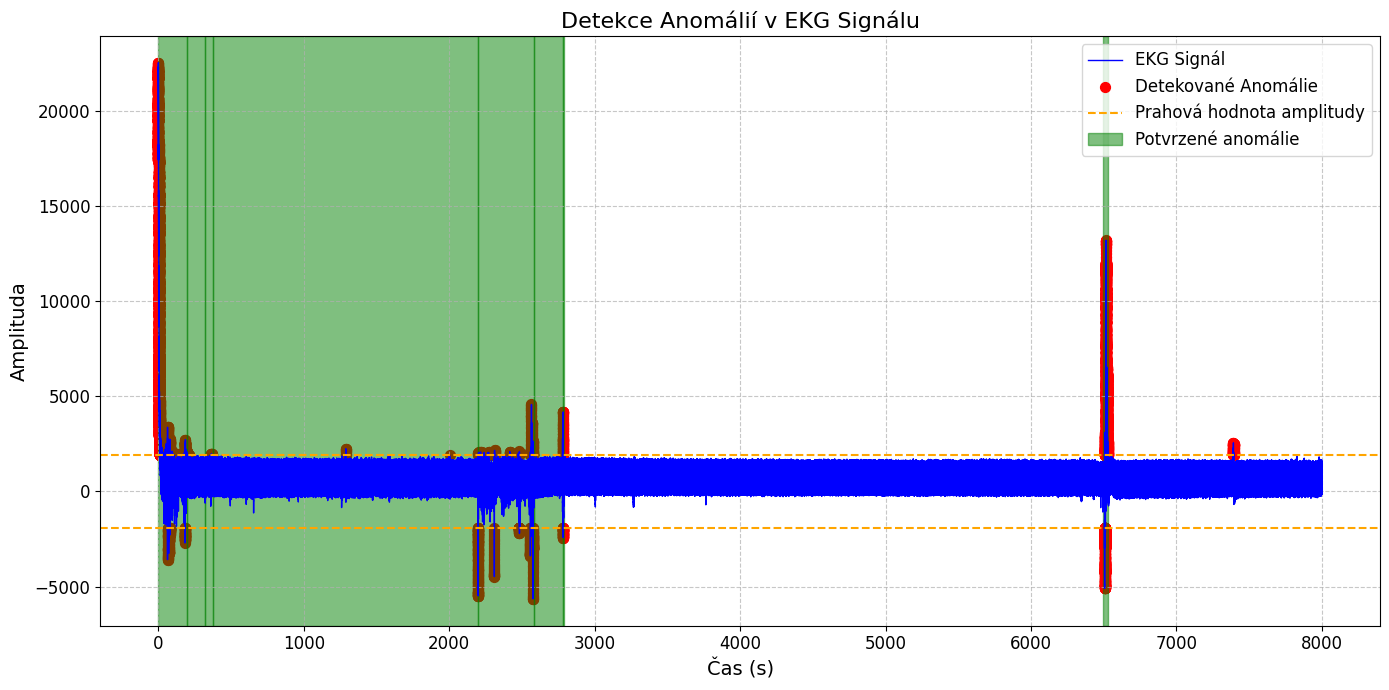

In [ ]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro detekci anomálií na základě amplitudy
def detect_anomalies_amplitude(signal):
    mean_amplitude = np.mean(signal)
    std_amplitude = np.std(signal)
    
    # Dynamické prahování
    threshold_amplitude = mean_amplitude + 3.7 * std_amplitude
    anomalies = np.where(np.abs(signal) > threshold_amplitude)[0]
    
    return anomalies, threshold_amplitude

# Funkce pro zpracování signálu a porovnání s anotacemi
def process_signal(record_path, ann_path, sampling_rate=1000, duration=8000):
    try:
        record = wfdb.rdrecord(record_path)
        signal_length = len(record.p_signal)
        max_samples = min(sampling_rate * duration, signal_length)
        signal = record.p_signal[:max_samples, 0]

        # Detekce anomálií na základě amplitudy
        anomalies, threshold_amplitude = detect_anomalies_amplitude(signal)

        annotations = pd.read_csv(ann_path, header=None)
        annotation_start = annotations.iloc[:, 0].values
        annotation_end = annotations.iloc[:, 1].values

        valid_annotations = (annotation_start < max_samples) & (annotation_end < max_samples)
        annotation_start = annotation_start[valid_annotations]
        annotation_end = annotation_end[valid_annotations]

        matching_annotations = sum(1 for start, end in zip(annotation_start, annotation_end) if any(start <= anomaly < end for anomaly in anomalies))
        total_annotations = len(annotation_start)

        num_anomalies = len(anomalies)
        success_rate = matching_annotations / total_annotations if total_annotations > 0 else 0

        # Vytvoření tabulky se statistickými ukazeli
        stats = {
            'Statistika': ['Počet shodných anomálií', 'Úspěšnost detekce (%)'],
            'Hodnota': [matching_annotations, success_rate * 100]
        }
        stats_df = pd.DataFrame(stats)
        print(stats_df)

        
        time = np.arange(len(signal)) / sampling_rate
        plt.figure(figsize=(14, 7))
        plt.plot(time, signal, label='EKG Signál', color='blue', linewidth=1)
        plt.scatter(time[anomalies], signal[anomalies], color='red', label='Detekované Anomálie', zorder=1, s=50)

        # Vyznačení prahové hodnoty
        plt.axhline(y=threshold_amplitude, color='orange', linestyle='--', label='Prahová hodnota amplitudy')
        plt.axhline(y=-threshold_amplitude, color='orange', linestyle='--')

        # Zobrazení anotací (zelený obdélník pouze tam, kde je detekovaná anomálie)
        for start, end in zip(annotation_start, annotation_end):
            # Kontrola, zda existuje nějaká detekovaná anomálie v tomto úseku
            matching_anomalies = [anomaly for anomaly in anomalies if start <= anomaly < end]
            if matching_anomalies:
                plt.axvspan(start / sampling_rate, end / sampling_rate, color='green', alpha=0.5, label='Potvrzené anomálie' if start == annotation_start[0] else "")

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Čas (s)', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, loc='upper right')
        plt.tight_layout()
        plt.show()

        return num_anomalies, matching_annotations, success_rate

    except Exception as e:
        print(f"Chyba při zpracování {record_path}: {e}")
        return 0, 0, 0

record_path = 'data/100001/100001_ECG'  # Cesta k souboru EKG signálu
ann_path = 'data/100001/100001_ANN.csv'  # Cesta k souboru anotací

num_anomalies, num_matching, success_rate = process_signal(record_path, ann_path)

                Statistika    Hodnota
0  Počet shodných anomálií  21.000000
1    Úspěšnost detekce (%)  77.777778


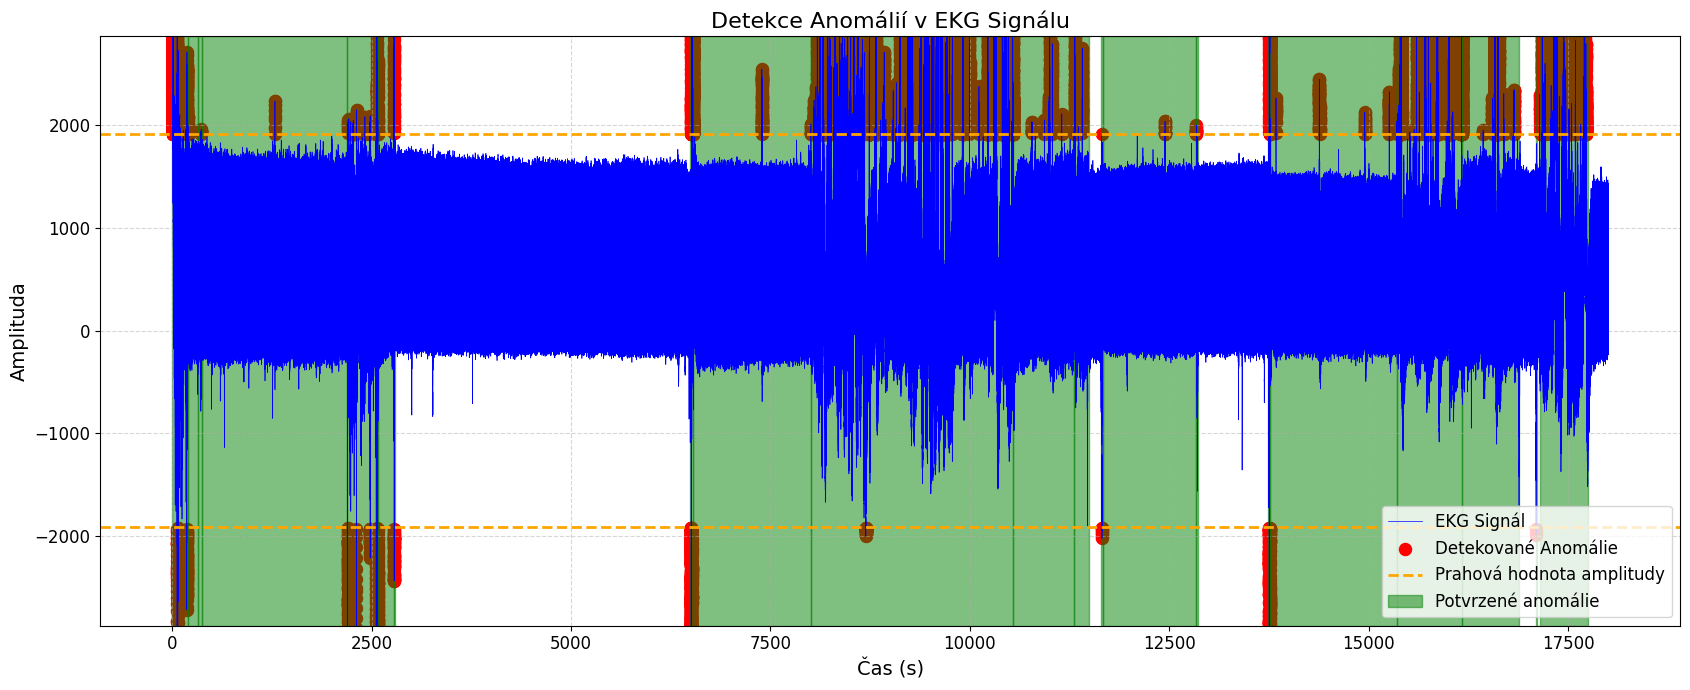

In [118]:
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt

# Funkce pro detekci anomálií na základě amplitudy
def detect_anomalies_amplitude(signal):
    mean_amplitude = np.mean(signal)
    std_amplitude = np.std(signal)
    
    # Dynamické prahování
    threshold_amplitude = mean_amplitude + 3.7 * std_amplitude
    anomalies = np.where(np.abs(signal) > threshold_amplitude)[0]
    
    return anomalies, threshold_amplitude

# Funkce pro zpracování signálu a porovnání s anotacemi
def process_signal(record_path, ann_path, sampling_rate=1000, duration=18000):
    try:
        record = wfdb.rdrecord(record_path)
        signal_length = len(record.p_signal)
        max_samples = min(sampling_rate * duration, signal_length)
        signal = record.p_signal[:max_samples, 0]

        # Detekce anomálií na základě amplitudy
        anomalies, threshold_amplitude = detect_anomalies_amplitude(signal)

        signal -= np.mean(signal)

        annotations = pd.read_csv(ann_path, header=None)
        annotation_start = annotations.iloc[:, 0].values
        annotation_end = annotations.iloc[:, 1].values

        valid_annotations = (annotation_start < max_samples) & (annotation_end < max_samples)
        annotation_start = annotation_start[valid_annotations]
        annotation_end = annotation_end[valid_annotations]

        matching_annotations = sum(1 for start, end in zip(annotation_start, annotation_end) if any(start <= anomaly < end for anomaly in anomalies))
        total_annotations = len(annotation_start)

        num_anomalies = len(anomalies)
        success_rate = matching_annotations / total_annotations if total_annotations > 0 else 0

        # Vytvoření tabulky se statistickými ukazeli
        stats = {
            'Statistika': ['Počet shodných anomálií', 'Úspěšnost detekce (%)'],
            'Hodnota': [matching_annotations, success_rate * 100]
        }
        stats_df = pd.DataFrame(stats)
        print(stats_df)

        time = np.arange(len(signal)) / sampling_rate
        plt.figure(figsize=(17, 7))
        plt.plot(time, signal, label='EKG Signál', color='blue', linewidth=0.5)

        # Zvýraznění detekovaných anomálií
        plt.scatter(time[anomalies], signal[anomalies], color='red', label='Detekované Anomálie', zorder=1, s=75)

        # Vyznačení prahové hodnoty
        plt.axhline(y=threshold_amplitude, color='orange', linestyle='--', linewidth=2, label='Prahová hodnota amplitudy')
        plt.axhline(y=-threshold_amplitude, color='orange', linestyle='--', linewidth=2)

        # Zobrazení anotací (zelený obdélník pouze tam, kde je detekovaná anomálie)
        for start, end in zip(annotation_start, annotation_end):
            # Kontrola, zda existuje nějaká detekovaná anomálie v tomto úseku
            matching_anomalies = [anomaly for anomaly in anomalies if start <= anomaly < end]
            if matching_anomalies:
                plt.axvspan(start / sampling_rate, end / sampling_rate, color='green', alpha=0.5, label='Potvrzené anomálie' if start == annotation_start[0] else "")

        plt.ylim(-1.5 * threshold_amplitude, 1.5 * threshold_amplitude)

        plt.grid(True, linestyle='--', alpha=0.5)

        plt.title('Detekce Anomálií v EKG Signálu', fontsize=16)
        plt.xlabel('Čas (s)', fontsize=14)
        plt.ylabel('Amplituda', fontsize=14)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12, loc='lower right')
        plt.tight_layout()
        plt.show()

        return num_anomalies, matching_annotations, success_rate

    except Exception as e:
        print(f"Chyba při zpracování {record_path}: {e}")
        return 0, 0, 0

record_path = 'data/100001/100001_ECG'  # Cesta k souboru EKG signálu
ann_path = 'data/100001/100001_ANN.csv'  # Cesta k souboru anotací

num_anomalies, num_matching, success_rate = process_signal(record_path, ann_path)